**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [4]:
!pip install deap

#@title -- Import of Necessary Packages -- { display-mode: "form" }
from IPython.display import Image, display
from deap import creator, base, tools, algorithms, gp
import matplotlib.pyplot as plt
import math, random, operator
import numpy as np
import pydot

     |████████████████████████████████| 163kB 5.0MB/s 


In [0]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
!mkdir -p output

def plot_syntax_tree(gp, ind, show=True):
    nodes, edges, labels = gp.graph(ind)
    graph = pydot.graph_from_edges(edges)

    for node in nodes:
        graph.add_node(pydot.Node(node, label=labels[node]))

    if show:
        img = Image(graph.create_png())
        display(img)

    return graph

# Example: Symbolic Regression Using Genetic Programming

Let us now apply the principles discussed in the previous notebook to another dataset. We will start by providing the data:

In [0]:
data = np.array([
[0.0, 1.0],
[0.5, 1.4931771388673793],
[1.0, 1.9276534171979032],
[1.5, 2.1824341048795457],
[2.0, 2.055579835457676],
[2.5, 1.2877294178633996],
[3.0, -0.3575364988725189],
[3.5, -2.95507478805141],
[4.0, -6.245699714504593],
[4.5, -9.485343327921688],
[5.0, -11.398426999392417],
[5.5, -10.327837818056654],
[6.0, -4.652040019335036],
[6.5, 6.524605241495308],
[7.0, 22.51031040172003],
[7.5, 40.231409246330685],
[8.0, 53.8716299518633],
[8.5, 55.37625638130115],
[9.0, 36.18659353549469],
[9.5, -9.6834606461911],
])

X = data[:, 0]
Y = data[:, 1]

We visualize the data:

Text(0, 0.5, 'y')

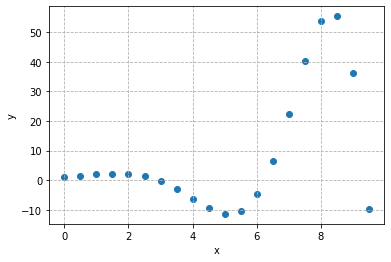

In [7]:
plt.figure()
plt.scatter(X, Y)
plt.grid(ls='--')
plt.xlabel("x")
plt.ylabel("y")

Our fitness function will again look at the mean squared error:

In [0]:
def evaluateGP(individual, X, Y):
    func = toolbox.compile(expr=individual)
    sqerrors = [(func(x) - y)**2 for x, y in zip(X, Y)]
    return math.fsum(sqerrors) / len(X), # the fitness can be multidimensional;
                                         # we return it as an tuple, hence the comma

## Terminals and Non-Terminals

We will next create a set of terminals and non-terminals that GP will be able to select from. We specify that our function will have a single argument and that it will be named 'x'. We also add some terminals and non-terminals.

In [0]:
pset = gp.PrimitiveSet("main", 1)
pset.renameArguments(ARG0='x')

try: del gp.randConstant
except: None

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
# integer constants
pset.addEphemeralConstant("randConstant", lambda: random.randint(-1, 1))
# real-valued constants
# pset.addEphemeralConstant("randConstant", lambda: random.uniform(-1, 1))

---

## Task 1: Add More Functions

**Add more potentially useful functions as terminals/non-terminals. You may also need to tune the procedure, which generates the random constants.**

Good candidates might include the sine, raising to the power of 2, 3 etc.

---

In [0]:
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.sin, 1)

def square_root(x):
    return math.sqrt(abs(x))

pset.addPrimitive(square_root, 1)





## Genetic Programming

Next we will set everything up so that we can run genetic programming. Since we already did this in the previous example, the code of the following cell is hidden.

In [51]:
#@title -- Setup for Genetic Programming -- { display-mode: "form" }
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evaluateGP, X=X, Y=Y)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

hof = tools.HallOfFame(1)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


---

## Task 2: Experiment with the Parameters

**Try to experiment with the parameters in the cell below – especially with the population size and the number of generations. We have used the population size of 300 and the number of generations = 40. We might need more to get good results in our current example.**

---

In [52]:
pop = toolbox.population(n=500)
final_pop = algorithms.eaSimple(pop, toolbox, cxpb=0.5,
                                mutpb=0.1, ngen=60,
                                stats=mstats, halloffame=hof)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min   	nevals	std    	avg  	gen	max	min	nevals	std    
0  	500   	566.156	0  	6758.63	307.02	500   	478.523	3.484	0  	7  	2  	500   	1.45799
1  	293   	468.13 	1  	3463.48	41.7311	293   	224.635	3.77 	1  	13 	1  	293   	1.652  
2  	285   	632.49 	2  	109539 	41.7311	285   	4877.83	4.136	2  	12 	1  	285   	1.78927
3  	275   	399.056	3  	1788.61	15.7696	275   	189.692	4.612	3  	12 	1  	275   	2.01729
4  	286   	672.849	4  	109539 	15.7696	286   	4957.58	5.2  	4  	13 	1  	286   	2.34009
5  	309   	3016.4 	5  	986093 	15.7696	309   	44711.4	5.792	5  	14 	1  	309   	2.47078
6  	283   	6579.74	6  	986093 	15.7696	283   	63786.6	6.83 	6  	15 	1  	283   	2.63839
7  	239   	7008.4 	7  	1.78885e+06	15.7696	239   	83581  	7.526	7  	22 	1  	239   	2.65355
8

## Evaluating the Results

We display the resulting individual and its fitness:

In [53]:
best_ind = hof[0]

print("Individual: {}\nfitness = {}".format(
    best_ind, best_ind.fitness.values[0]))

Individual: mul(mul(x, square_root(mul(add(sin(x), add(sin(add(-1, x)), add(sin(add(-1, x)), x))), add(-1, square_root(mul(add(-1, add(sin(square_root(mul(x, add(-1, add(add(add(sin(add(-1, x)), x), add(-1, x)), x))))), add(-1, x))), add(sin(add(-1, x)), add(sin(add(-1, add(-1, x))), square_root(mul(x, x)))))))))), sin(sin(x)))
fitness = 1.3945843317893716


Our syntax tree looks as follows:

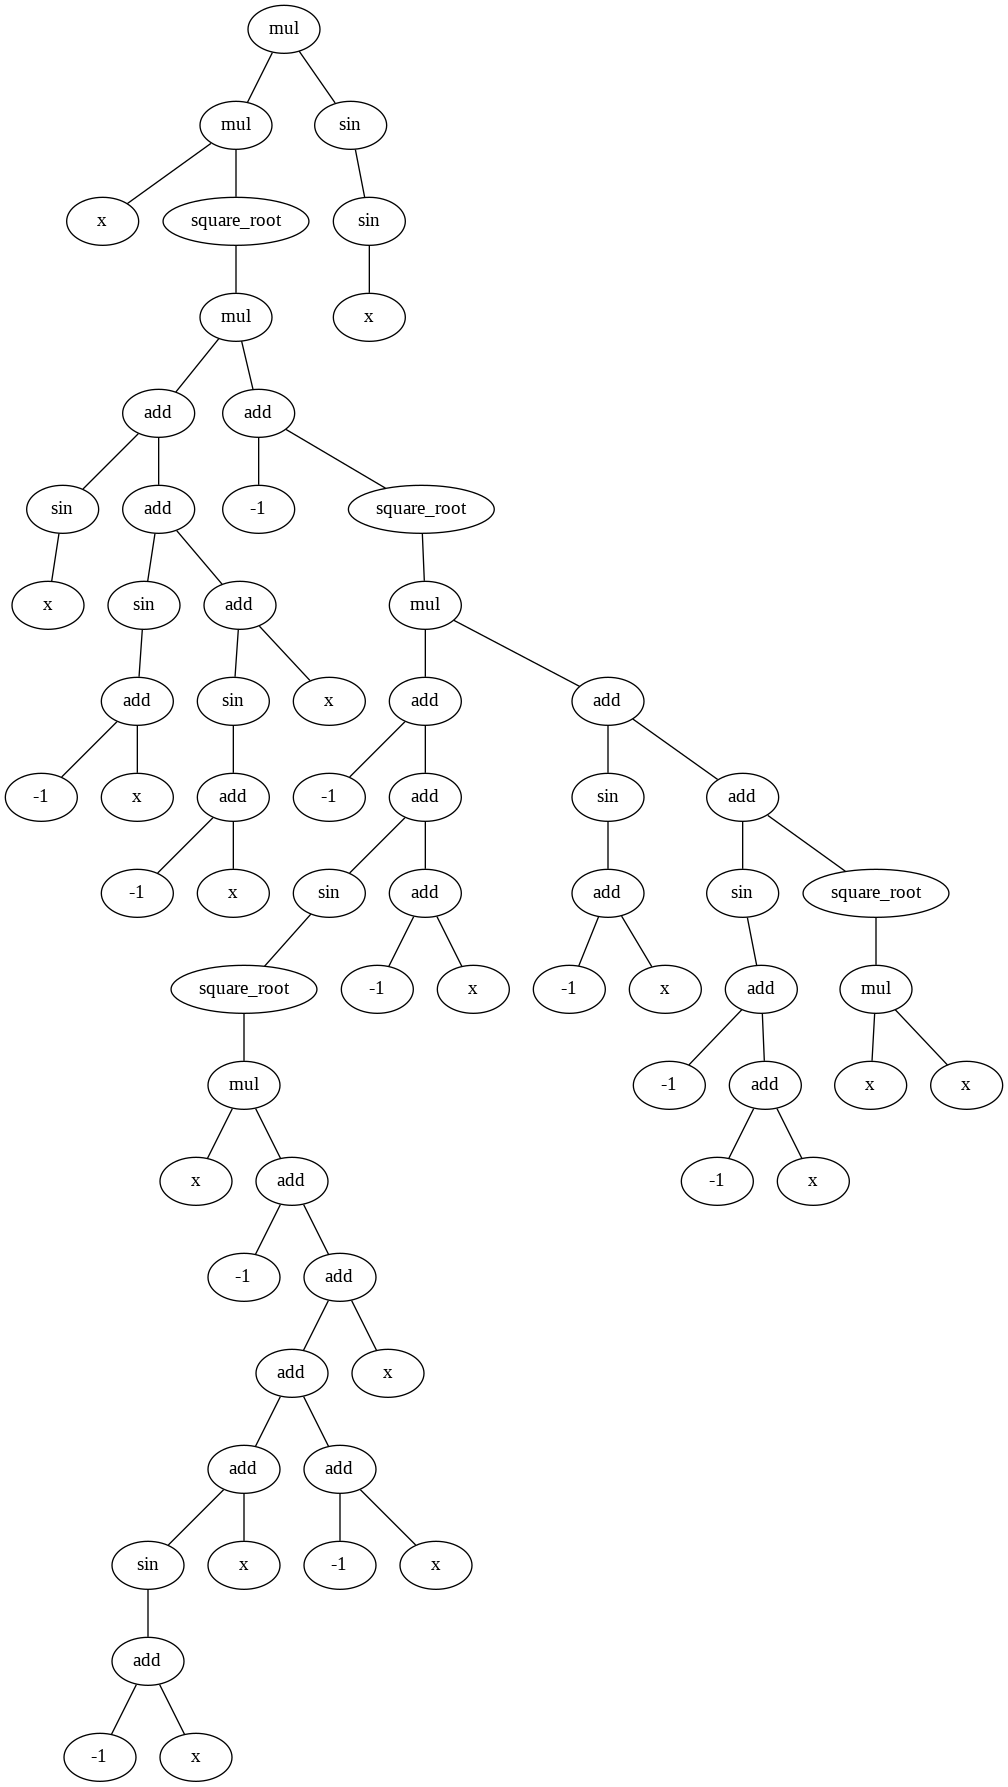

In [54]:
plot_syntax_tree(gp, best_ind);

### The Regression Curve

Finally, we can also plot our original data and the resulting regression curve.

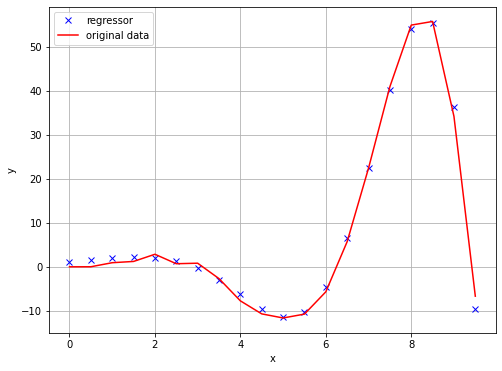

In [55]:
func = toolbox.compile(expr=best_ind)

plt.figure(figsize=(8, 6))
plt.plot(X, Y, 'bx')
plt.plot(X, [func(x) for x in X], 'r')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")

plt.legend(["regressor", "original data"])